In [56]:
import pandas as pd

In [57]:
empluzz = pd.read_csv("Unemployment2023.csv")

empluzz = empluzz[(empluzz["Attribute"] == "Median_Household_Income_2022") & (empluzz["Area_Name"].str.contains("County"))]
empluzz.rename(columns={"FIPS_Code": "LocationID", "Value": "Median_Household_Income_2022"}, inplace=True)
empluzz["LocationID"] = empluzz["LocationID"].astype(str)

empluzz = empluzz[["LocationID", "Median_Household_Income_2022"]]
print(empluzz.head())

    LocationID  Median_Household_Income_2022
294       1001                       70148.0
395       1003                       71704.0
496       1005                       41151.0
597       1007                       54309.0
698       1009                       60553.0


In [58]:
census = pd.read_csv("cc-est2024-alldata.csv", encoding="latin-1")

census = census[(census["YEAR"] == 4) & census["AGEGRP"] == 0]

census["LocationID"] = census["STATE"].astype(str).str.zfill(2) + census["COUNTY"].astype(str).str.zfill(3)

census["Pct_Black"] = census["BA_MALE"] + census["BA_FEMALE"]
census["Pct_Hispanic"] = census["H_MALE"] + census["H_FEMALE"]
census["Pct_White"] = census["WA_MALE"] + census["WA_FEMALE"]
census["Pct_Asian"] = census["AA_MALE"] + census["AA_FEMALE"]

census["Pct_Black"] = census["Pct_Black"] / census["TOT_POP"] 
census["Pct_Hispanic"] = census["Pct_Hispanic"] / census["TOT_POP"]
census["Pct_White"] = census["Pct_White"] / census["TOT_POP"]
census["Pct_Asian"] = census["Pct_Asian"] / census["TOT_POP"]

census["LocationID"] = census["LocationID"].astype(str)

census = census[["LocationID", "Pct_Black", "Pct_Hispanic", "Pct_Asian", "Pct_White"]]

In [59]:
df = pd.read_csv("PLACES__Local_Data_for_Better_Health__County_Data_2024_release_20250620.csv", engine="python")
df.describe()

,Year,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,TotalPop18plus,LocationID
count,240886.000000,240886.000000,240886.000000,240886.000000,2.408860e+05,2.408860e+05,240886.000000
mean,2021.897777,25.793842,23.213787,28.436679,2.162907e+05,1.692237e+05,30372.252360
std,0.302941,21.806707,20.516978,23.057834,6.079978e+06,4.758322e+06,15112.488466
min,2021.000000,1.700000,1.500000,1.800000,5.100000e+01,3.700000e+01,59.000000
25%,2022.000000,9.800000,8.700000,11.000000,1.076900e+04,8.398000e+03,19021.000000
50%,2022.000000,17.700000,15.500000,20.100000,2.594000e+04,2.045900e+04,29161.000000
75%,2022.000000,33.900000,29.400000,38.500000,6.882600e+04,5.368600e+04,45077.000000
max,2022.000000,91.600000,90.000000,93.100000,3.332876e+08,2.608367e+08,56045.000000


In [60]:
df = df[df["Data_Value_Type"] == "Crude prevalence"].pivot(index=["LocationID", "LocationName"], columns="Short_Question_Text", values="Data_Value").reset_index().dropna()
df["LocationID"] = df["LocationID"].astype(str)
df = pd.merge(df, census, on="LocationID", how="inner").reset_index().dropna()

df = pd.merge(df, empluzz, on="LocationID", how="inner").reset_index().dropna()

print(df.head())


   level_0  index LocationID LocationName  All Teeth Lost  Annual Checkup  \
0        0      0      10001         Kent            13.0            78.5   
1        1      1      10001         Kent            13.0            78.5   
2        2      2      10001         Kent            13.0            78.5   
3        3      3      10001         Kent            13.0            78.5   
4        4      4      10001         Kent            13.0            78.5   

   Any Disability  Arthritis  Binge Drinking  COPD  ...  Social Isolation  \
0            28.6       28.7            14.7   7.4  ...              32.6   
1            28.6       28.7            14.7   7.4  ...              32.6   
2            28.6       28.7            14.7   7.4  ...              32.6   
3            28.6       28.7            14.7   7.4  ...              32.6   
4            28.6       28.7            14.7   7.4  ...              32.6   

   Stroke  Transportation Barriers  Utility Services Threat  \
0     3.9  

In [61]:
X = df[["Obesity", "Median_Household_Income_2022", "Pct_Black", "Pct_Hispanic", "Pct_White", "Pct_Asian"]] 
y = df["Diabetes"] / 100

X["Median_Household_Income_2022"] = X["Median_Household_Income_2022"] / 1000
X["Obesity"] = X["Obesity"] / 100

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)

/tmp/ipykernel_628716/107659549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Median_Household_Income_2022"] = X["Median_Household_Income_2022"] / 1000
/tmp/ipykernel_628716/107659549.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Obesity"] = X["Obesity"] / 100


In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


train_X, val_X, train_y, val_y = train_test_split(X_scaled, y, random_state=0)

In [63]:
model = LinearRegression()
model.fit(train_X, train_y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [64]:
val_predictions = model.predict(val_X)
mean_absolute_error(val_y, val_predictions)

0.011944115097003698

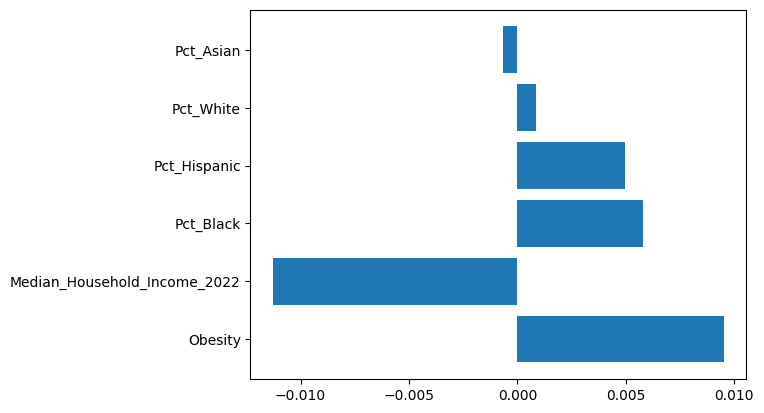

Index(['Obesity', 'Median_Household_Income_2022', 'Pct_Black', 'Pct_Hispanic',
       'Pct_White', 'Pct_Asian'],
      dtype='object') [ 0.00952178 -0.01127111  0.00577687  0.00497155  0.00086688 -0.00067192]


In [65]:
import matplotlib.pyplot as plt

features = X_scaled.columns
coef = model.coef_
plt.barh(features, coef)
plt.show()

print(features, coef)

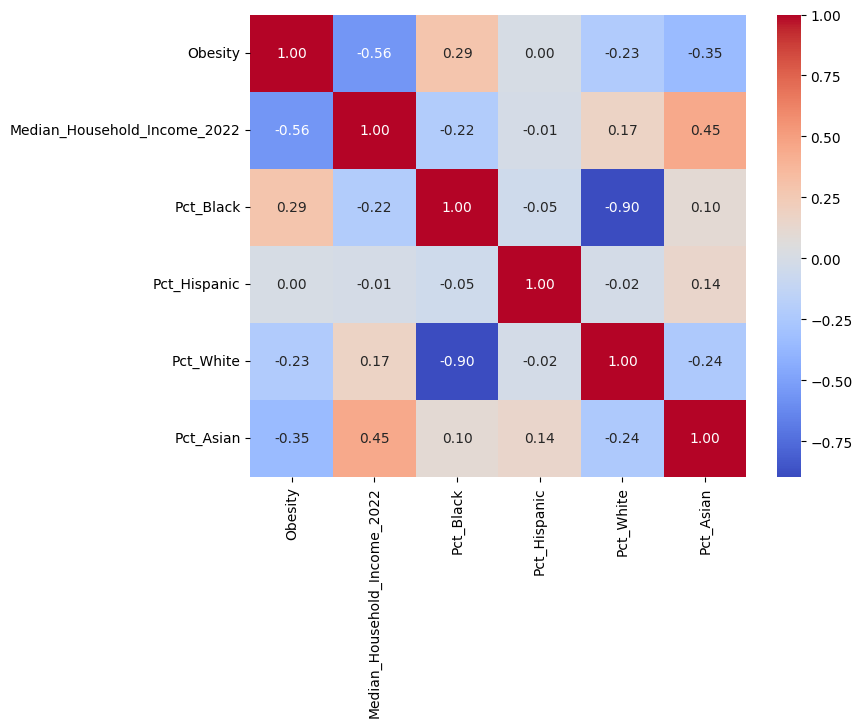

In [66]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(X_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

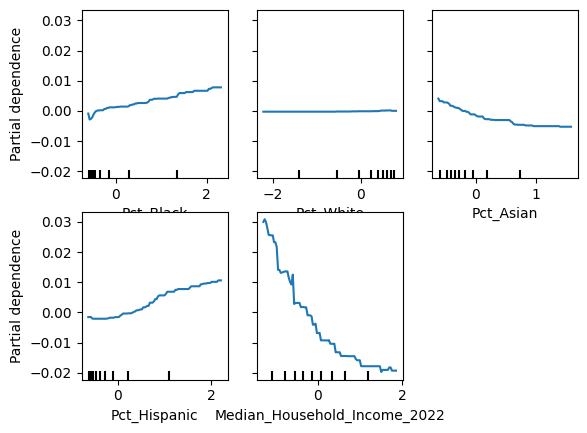

In [67]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor().fit(X_scaled, y)
PartialDependenceDisplay.from_estimator(gb_model, X_scaled, features=["Pct_Black", "Pct_White", "Pct_Asian", "Pct_Hispanic", "Median_Household_Income_2022"])
plt.show()

In [68]:
std_df = pd.DataFrame({"Feature": X.columns, "Standard Deviation": scaler.scale_})

print(std_df)

                        Feature  Standard Deviation
0                       Obesity            0.042199
1  Median_Household_Income_2022           15.060400
2                     Pct_Black            0.139616
3                  Pct_Hispanic            0.150321
4                     Pct_White            0.153232
5                     Pct_Asian            0.021344
